# Model to Run
This section lets the user edit on what model parameters to run, the model directory and parameters should exist prior to changing the file path

In [1]:
# All editable variables
model_file_path = "models/model_3"
# If preprocessing needs to run
load_model = False

# Dependencies

In [2]:
import cv2
from multiprocessing import Pool
from models import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import json
from os import path, mkdir
from PIL import Image
import re

import keras
from argparse import ArgumentParser
import tensorflow as tf

In [3]:
# Get model parameters
try:
    params = json.load(open(model_file_path + '/parameters.json'))

    # Model to use
    model_is_VAE = params['is_VAE']
    # Model parameters
    multiplier = params['multiplier']
    latent_size = params['latent_size']
    input_shape = params['input_shape']

    # Training parameters
    epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Dataset Path
    dataset_file_path = params['dataset_path']

except:
    raise Exception("No parameters.json file found in the model's directory.")

In [4]:
# each array contains the training, validation, and testing in order
image_datasets = {'train': []}
for dataset_name in image_datasets.keys():
    for image_path in glob.glob(f'{dataset_file_path}/{dataset_name}/*.png'):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_datasets[dataset_name].append(image)
    image_datasets[dataset_name] = np.array(image_datasets[dataset_name])

# Model Training
This section creates and trains the model

In [5]:
if __name__ == "__main__":

    if model_is_VAE:
        model = VAE(False, input_shape, multiplier, latent_size)
    else:
        model = UPAE(True, input_shape, multiplier, latent_size)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.build(input_shape=(None,) + tuple(input_shape))

    model.compile(optimizer= optimizer, loss='mse'
                  ,metrics=[tf.keras.metrics.Accuracy()])
    
    model.summary()

    # Where images of each epoch will be saved
    # save_directory = 'Images/images_epochs' #edited in models where automatically make folder if non existent
    save_directory = model_file_path + '/callback_images'
    save_callback = SaveImageCallback(image_datasets['train'], save_directory=save_directory)
    
    if load_model:
        model.load_weights(model_file_path + '/model_weights')
    else:
        history_train = model.fit(image_datasets['train'], 
            epochs=epochs, 
            batch_size=batch_size,
            validation_split=0.15,
            callbacks=[save_callback])
        
        # Saving the model's history
        json.dump(history_train.history, open(model_file_path + '/history.json', 'w'))

        #Save weights
        model.save_weights(model_file_path + '/model_weights', save_format='tf')
   
    

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16, 16, 128)   

c:\Users\SKill\anaconda3\envs\tf-gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "upae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_decoder (encoder_de  multiple                 19702594  
 coder)                                                          
                                                                 
Total params: 19,702,606
Trainable params: 19,692,098
Non-trainable params: 10,508
_________________________________________________________________
Epoch 1/5
UPAE Training
UPAE Training
2/2 [==============================] - ETA: 0s - mse_loss: 6600.5762 - total_loss: 4604.3452 - loss1: 4603.7476 - loss2: 0.5976 - reconstruction_loss: 347.9166 - accuracy: 0.0000e+00UPAE Validation
UPAE Loss
callback predict
2/2 [==============================] - 4s 682ms/step - mse_loss: 6600.5762 - total_loss: 4604.3452 - loss1: 4603.7476 - loss2: 0.5976 - reconstruction_loss: 295.1467 - accuracy: 0.0000e+00 - val_mse_loss: 5275.6748 - val_total_loss: 592.8054 - 

# Creating of different Plots

In [6]:
# Create directory for saving images
save_directory = model_file_path + '/plots'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


In [7]:
# Get history of data
history = history_train.history

def create_plot(history, metric, title, save_name):
    plt.plot(history[metric], label=metric)
    plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.savefig(f'{save_directory}/{save_name}', dpi=300)
    plt.close()

# Check if UPAE or not
if model_is_VAE:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for reconstruction_loss
    create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
    # Create plot for kl_loss
    create_plot(history, 'kl_loss', 'KL Loss per Epoch', 'kl_loss.png')
else:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for total loss
    create_plot(history, 'total_loss', 'Total Loss per Epoch', 'total_loss.png')
    # Create plot for loss1
    create_plot(history, 'loss1', 'Loss 1 per Epoch', 'loss1.png')
    # Create plot for loss2
    create_plot(history, 'loss2', 'Loss 2 per Epoch', 'loss2.png')
    # Create plot for binary_crossentropy
    create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
    # Create plot for accuracy
    create_plot(history, 'accuracy', 'Accuracy per Epoch', 'accuracy.png')
    

# Testing of the Model with the Test Set
This section tests the model with the current test set
TODO: 
- Get the label of each image in the test set
- Test the images
- Create Linear Regression for the abnormality score to get the threshold for determining abnormal or normal images

In [ ]:
# Get labels of each image in the image_datasets['test']
test_images = []
labels = []
for image_path in glob.glob(f'{dataset_file_path}/test/*.png'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get if it contains positive or negative
    if 'positive' in image_path:
        test_images.append(image)
        labels.append(1)
    else:
        test_images.append(image)
        labels.append(0)
test_images = np.array(test_images)

In [ ]:
reconstructed_images = model.predict(test_images, batch_size=batch_size)

not callback predict


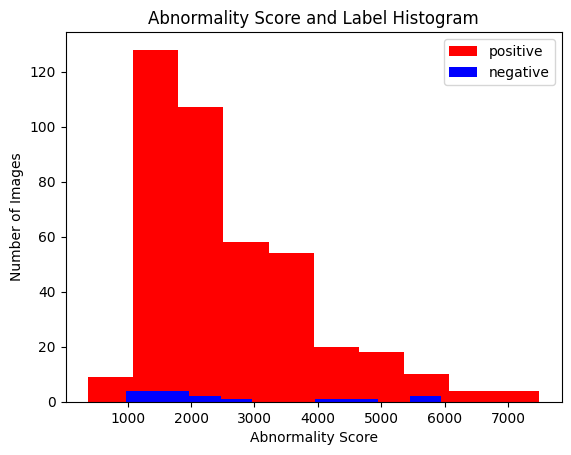

In [ ]:
# Histogram for Positives and Negatives of the testing set
positive = []
negative = []
for i in range(len(labels)):
    if labels[i] == 1:
        positive.append(reconstructed_images[1][i])
    else:
        negative.append(reconstructed_images[1][i])
plt.hist(positive, color='red', label='positive')
plt.hist(negative, color='blue', label='negative')
# Get x and y labels
plt.xlabel('Abnormality Score')
plt.ylabel('Number of Images')
plt.title("Abnormality Score and Label Histogram")
plt.legend()
plt.savefig(f'{save_directory}/testing_abnormality_scores.png')

# Getting of best threshold

In [9]:
def classify_image(score, threshold):
    if score >= threshold:
        return 1
    else:
        return 0

def get_threshold_range(abnormality_scores, num_std):
    mean_score = np.mean(abnormality_scores)
    std_score = np.std(abnormality_scores)

    lower_threshold = mean_score - (num_std * std_score)
    upper_threshold = mean_score + (num_std * std_score)

    return lower_threshold, upper_threshold

def calculate_f1_score(predicted_labels, true_labels):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for predicted, true in zip(predicted_labels, true_labels):
        if predicted == 1 and true == 1:
            true_positives += 1
        elif predicted == 1 and true == 0:
            false_positives += 1
        elif predicted == 0 and true == 1:
            false_negatives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score, precision, recall, true_positives, false_positives, false_negatives

def find_optimal_threshold(abnormality_scores, labels):
    best_threshold = None
    best_metric = 0.0

    # Get a range of threshold values
    lower_threshold, upper_threshold = get_threshold_range(abnormality_scores, num_std=3)
    threshold_range = np.linspace(lower_threshold, upper_threshold, 50)

    
    # Iterate over a range of threshold values
    for threshold in threshold_range:
        predicted_labels = [classify_image(score, threshold) for score in abnormality_scores]

        # Evaluate performance metric (e.g., accuracy, precision, recall, F1 score)
        metric, precision, recall, true_postivies, false_positives, false_negatives = calculate_f1_score(predicted_labels, labels)

        # Update the best threshold if the metric improves
        if metric > best_metric:
            print("Current best Threshold: ", threshold, "\nCurrent best F1 Score: ", metric)
            print("Current best Precision: ", precision, "\nCurrent best Recall: ", recall)
            print("\nCurrent best True Positives: ", true_postivies, "\nCurrent best False Positives: ", 
                  false_positives, "\nCurrent best False Negatives: ", false_negatives)
            print()
            best_metric = metric
            best_threshold = threshold


    return best_threshold


In [10]:
find_optimal_threshold(np.float32(reconstructed_images[1]), labels)

Current best Threshold:  -947.57568359375 
Current best F1 Score:  0.9821215733015495
Current best Precision:  0.9648711943793911 
Current best Recall:  1.0

Current best True Positives:  412 
Current best False Positives:  15 
Current best False Negatives:  0



-947.57568359375

# Saving of final reconstructed images 

In [ ]:
# Create directory in models folder for reconstructed images
dataset_name = dataset_file_path.split('/')[-1]
reconstructed_images_path = model_file_path + "/" + dataset_name
if not path.exists(reconstructed_images_path):
    mkdir(reconstructed_images_path)

In [ ]:
def save_compared_reconstructed_image(original_image, reconstructed_image, abnormality_score, file_path, image_index,
                                      label):
    # Put Images in cv2
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    reconstructed_image = cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2BGR)
    # Convert reconstructed image to uint8
    reconstructed_image = reconstructed_image.astype(np.uint8)
    concatenated_img = cv2.hconcat([original_image, reconstructed_image])
    # Save the image
    cv2.imwrite(f'{file_path}/Image_{image_index}_{abnormality_score}_{label}.png', concatenated_img)

In [ ]:
for i in range(len(test_images)):
    save_compared_reconstructed_image(test_images[i], np.array(reconstructed_images[0][i]), reconstructed_images[1][i],
                                      reconstructed_images_path, i, labels[i])


# GIF for Callback_images

In [ ]:
def extract_epoch(filename):
    match = re.search(r'epoch_(\d+)_', filename)
    if match:
        return int(match.group(1))
    return 0

def create_gif(folder_path, output_path, duration=50):
    images = []
    
    # Get all image file names from the folder
    filenames = os.listdir(folder_path)
    filenames = sorted(filenames, key=lambda x: extract_epoch(x))

    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path = os.path.join(folder_path, filename)
            image = Image.open(file_path)
            images.append(image)
    
    # Save the images as a GIF
    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)


In [ ]:
gif_folder_path = model_file_path + "/" + "callback_images"
image_folders = ['image0', 'image1', 'image2', 'image3']

for i,folder in enumerate(image_folders):
    curr_folder = gif_folder_path + "/" + folder
    gif_output_path = gif_folder_path + "/" + f"image{i}.gif"
    print(f"Creating GIF for: image{i}")
    create_gif(curr_folder, gif_output_path)

In [ ]:
model_file_path